# Imports & Globals

In [1]:
import pickle
import pandas as pd
import numpy as np
from yaml import safe_load
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True
%matplotlib inline

In [2]:
from StringProcessing import preprocessInput, encode_pad_tag, balance_complete_set

In [3]:
from SiameseModel import CosineDistance, ContrastiveLoss 

tf.version:  2.9.1
tf.keras.version:  2.9.0
tf.config.devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-10-21 13:07:26.534749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:07:26.557842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:07:26.557999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:07:26.558471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
from ModelEvaluation import find_Model_ranks, find_Levenshtein_ranks, find_Gesalt_ranks

In [5]:
#Maximum sequence length including padding
global MAXLEN
with open('LSTM65.yaml', 'r') as file:
    model_config = safe_load(file)
    MAXLEN = model_config['MAXLEN']

# Pickled Datasets

In [6]:
dUnique_df = pd.read_pickle("../data/dUnique_df.pkl")
dfneg2 = pd.read_pickle("../data/dfneg2.pkl")
test = pd.read_pickle("../data/test.pkl")

--------------------------------

# Build model, load weights and evaluate on test data

In [7]:
model = tf.keras.models.load_model(
    './saved_models/{}'.format(model_config["Model_Name"]), 
    custom_objects = {
        'CosineDistance': CosineDistance,
        'ContrastiveLoss': ContrastiveLoss
    }, 
    compile=True, 
    options=None
)
model.summary()

2022-10-21 13:07:27.417958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:07:27.418156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:07:27.418261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:07:27.418390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 13:07:27.418490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

2022-10-21 13:07:33.203752: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-21 13:07:33.248895: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-21 13:07:33.257545: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-21 13:07:33.289718: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-21 13:07:33.391792: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes at

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 65)]         0           []                               
                                                                                                  
 model (Functional)             (None, 65)           76425       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

---------------------------------------------------------------

# Evaluation

## Unique target labels

In [8]:
dUnique_df.head()

,dUnique_label,dUnique_seq_padded
0,AAI,"[1, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AARONSROD,"[1, 1, 18, 15, 14, 19, 18, 15, 4, 0, 0, 0, 0, ..."
2,ABIES ALBA,"[1, 2, 9, 5, 19, 27, 1, 12, 2, 1, 0, 0, 0, 0, ..."
3,ABSINTHE,"[1, 2, 19, 9, 14, 20, 8, 5, 0, 0, 0, 0, 0, 0, ..."
4,ABSINTHE WORMWOOD,"[1, 2, 19, 9, 14, 20, 8, 5, 27, 23, 15, 18, 13..."


In [9]:
dUnique_df.index.size

1879

In [10]:
latin_2_common = preprocessInput('../data/vocabulary_LB_to_common_names_09082022.tsv', maxlen= MAXLEN, reflexive=True, balance = False, noise=None, sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lb        1299 non-null   object
 1   mappings  1299 non-null   object
dtypes: object(2)
memory usage: 20.4+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['lb', 'mappings'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 321 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------

In [11]:
common_2_latin = preprocessInput('../data/positive-unmapped-pairs-common-name-or-latin-binomial-copies.tsv', maxlen= MAXLEN, reflexive=True, balance = False, noise=None, sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   common_name     728 non-null    object
 1   latin_binomial  728 non-null    object
dtypes: object(2)
memory usage: 11.5+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['common_name', 'latin_binomial'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 0 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 728 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 2 columns):
 #   Column  Non-Null Count 

In [12]:
gsrs_2_common = preprocessInput('../data/positive-unmapped-pairs-gsrs-name-to-common-name.tsv', maxlen= MAXLEN, reflexive=True, balance = False, noise=None, sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         10838 non-null  object
 1   common_name  199 non-null    object
dtypes: object(2)
memory usage: 169.5+ KB
None
Processing file: ----------------------------------------
Renaming colums:
	Current names: Index(['name', 'common_name'], dtype='object')
	New names: Index(['x', 'y'], dtype='object')
Dropping row with empty cells:
	Dropped 10639 rows with empty cells.
	Cleaning string sequences.
	Uppercasing string sequences.
Dropping sequences longer than the maxlen of 65:
	Dropped 0 that exceeded the maximum sequence length.
Dropping duplicate sequences:
	Dropped 0 duplicate sequences.
Done processing: ---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  --

In [13]:
# vocab = pd.read_csv('../data/lb_to_common_names.csv')
# vocab = vocab[['latin_binomial_clean','common_name_clean']].rename(columns={'latin_binomial_clean': "x", 'common_name_clean': "y"})
# vocab.info()

In [14]:
equivalence_set = pd.concat([latin_2_common, common_2_latin, gsrs_2_common], ignore_index=True)
equivalence_set.drop_duplicates(subset=['x', 'y'], inplace=True)

In [15]:
equivalence_set[equivalence_set["x"] == "CRANBERRY"]

,x,y
2230,CRANBERRY,VACCINIUM MACROCARPON


# Evaluating on test data - NP names only

# Evaluation of drug name predictions
----------------------------
### Find ranks 1-5 from the predicted and fuzzy matches for the matching cases in the test data

# Create a sample from the test set to evaluate

In [16]:
# positive_pairs = matches.sample(n=100)
positive_pairs = test.loc[test["Match"] == 1].sample(n=1000)

In [17]:
positive_pairs.index.size

1000

--------------------------------------

In [18]:
positive_pairs.head()

,x,y,Processed_x,Processed_y,Match,Distance
1609556,EQUQIZWSETMMB HTEY MALYEWOLE,EQUISETUM HYEMALE WHOLE,"[5, 17, 21, 17, 9, 26, 23, 19, 5, 20, 13, 13, ...","[5, 17, 21, 9, 19, 5, 20, 21, 13, 27, 8, 25, 5...",1,0
1857812,HAILEAN JBIIS,ACHILLEA NOBILIS,"[8, 1, 9, 12, 5, 1, 14, 27, 10, 2, 9, 9, 19, 0...","[1, 3, 8, 9, 12, 12, 5, 1, 27, 14, 15, 2, 9, 1...",1,0
2395435,AOLAQM ANGXIVN,SOLANUM ANGUIVI,"[1, 15, 12, 1, 17, 13, 27, 1, 14, 7, 24, 9, 22...","[19, 15, 12, 1, 14, 21, 13, 27, 1, 14, 7, 21, ...",1,0
495052,NEOTEHAWVTHRN,ONESTYLE HAWTHORN,"[14, 5, 15, 20, 5, 8, 1, 23, 22, 20, 8, 18, 14...","[15, 14, 5, 19, 20, 25, 12, 5, 27, 8, 1, 23, 2...",1,0
1223778,CVSVMMON YHQOGS JCHXESTVNUT,COMMON HORSE CHESTNUT,"[3, 22, 19, 22, 13, 13, 15, 14, 27, 25, 8, 17,...","[3, 15, 13, 13, 15, 14, 27, 8, 15, 18, 19, 5, ...",1,0


# Structure to contain the results

In [19]:
results = pd.DataFrame(index = ['Exact', 'Equivalent'], columns =['Siamese model', 'Levenshtein','Gesalt'])

----------------------------------------------------

# Predicted Match MRR Evaluation

In [20]:
Predicted = find_Model_ranks(model, df=positive_pairs, targets = dUnique_df, equivalence_set = equivalence_set, ranks=20, find_related_rank=True, report_distances=True)

2022-10-21 13:07:36.863401: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).
2022-10-21 13:07:39.636943: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f79dc004730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-10-21 13:07:39.636963: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2022-10-21 13:07:39.640209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR cras

In [21]:
Predicted.sample(n=5)

,x,y,Processed_x,Processed_y,Match,Distance,rank1,rank2,rank3,rank4,...,rank13_distance,rank14_distance,rank15_distance,rank16_distance,rank17_distance,rank18_distance,rank19_distance,rank20_distance,exact_rank,equivalent_rank
1231261,LEOMNRUS CDRDCA,COMMON MOTHERWORT,"[12, 5, 15, 13, 14, 18, 21, 19, 27, 3, 4, 18, ...","[3, 15, 13, 13, 15, 14, 27, 13, 15, 20, 8, 5, ...",1,0,LEONURUS CARDIACA,COMMON MOTHERWORT,MOTHERWORT,QUERCUS MARILANDICA,...,0.088994,0.104817,0.138613,0.139196,0.149018,0.153070,0.158900,0.162444,2.0,1.0
767142,QITSAQIALJ DENHRSCNAUZ,LENTISCUS,"[17, 9, 20, 19, 1, 17, 9, 1, 12, 10, 27, 4, 5,...","[12, 5, 14, 20, 9, 19, 3, 21, 19, 0, 0, 0, 0, ...",1,0,ASHWAGANDHA,SATINWALNUT,PISTACIA LENTISCUS,ALLIGATORWOOD,...,0.012582,0.014250,0.014405,0.014570,0.015651,0.019042,0.019312,0.025498,10.0,3.0
1763981,FJTCRYORIZC AINAVNAA,DACTYLORHIZA INCARNATA,"[6, 10, 20, 3, 18, 25, 15, 18, 9, 26, 3, 27, 1...","[4, 1, 3, 20, 25, 12, 15, 18, 8, 9, 26, 1, 27,...",1,0,MOMORDICA CHARANTIA,DACTYLORHIZA INCARNATA,QUERCUS INCANA,SUO CAO,...,0.044442,0.069134,0.070649,0.081339,0.085279,0.098792,0.107313,0.109830,2.0,2.0
1388486,OICEUS,COLEUS CRASSIFOLIUS WHOLE,"[15, 9, 3, 5, 21, 19, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 15, 12, 5, 21, 19, 27, 3, 18, 1, 19, 19, 9...",1,0,COLEUS,COCKLEBUR,PLECTRANTHUS AMBOINICUS WHOLE,VICKS PLANT WHOLE,...,0.000679,0.000710,0.000797,0.000879,0.000984,0.001084,0.001127,0.001231,inf,1.0
1809620,FVITSDX OINNBA,VITEX DONIANA,"[6, 22, 9, 20, 19, 4, 24, 27, 15, 9, 14, 14, 2...","[22, 9, 20, 5, 24, 27, 4, 15, 14, 9, 1, 14, 1,...",1,0,HAMAMELIS VIRGINIANA,SPOTTED ALDER,WINTER BLOOM,BITTER MELON,...,0.006866,0.006875,0.011603,0.013532,0.013896,0.014718,0.018064,0.018211,9.0,9.0


In [22]:
Models_mrr = Predicted.loc[:,['x', 'exact_rank', 'equivalent_rank']]
Models_mrr.loc[:,'exact_reciprocal_rank'] = 1/Models_mrr.loc[:, 'exact_rank']
Models_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/Models_mrr.loc[:, 'equivalent_rank']
Models_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,1000.000000,1000.000000
mean,0.421681,0.672271
std,0.414893,0.408108
min,0.000000,0.000000
25%,0.058824,0.250000
50%,0.250000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [23]:
#get median and stdev
# Models_mrr['exact_rank'].median(), Models_mrr['exact_rank'].std()

In [24]:
#get median and stdev
# Models_mrr['equivalent_rank'].median(), Models_mrr['equivalent_rank'].std()

In [25]:
# results.loc['Exact', 'Siamese model'] = 1/Models_mrr.index.size * Models_mrr['exact_reciprocal_rank'].sum()

In [26]:
# results.loc['Equivalent', 'Siamese model'] = 1/Models_mrr.index.size * Models_mrr['equivalent_reciprocal_rank'].sum()

In [27]:
results.loc['Exact', 'Siamese model'] = Models_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["mean"][0]

In [28]:
results.loc['Exact_std', 'Siamese model'] = Models_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["std"][0]

In [29]:
results.loc['Equivalent', 'Siamese model'] = Models_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["mean"][1]

In [30]:
results.loc['Equivalent_std', 'Siamese model'] = Models_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["std"][1]

In [31]:
results

,Siamese model,Levenshtein,Gesalt
Exact,0.421681,NaN,NaN
Equivalent,0.672271,NaN,NaN
Exact_std,0.414893,NaN,NaN
Equivalent_std,0.408108,NaN,NaN


--------------------------------------

# Comparison with fuzzy string match

# Fuzzy Levenshtein Match MRR Evaluation

In [32]:
Levenshtein = find_Levenshtein_ranks(positive_pairs, targets = dUnique_df, equivalence_set = equivalence_set, ranks=20, find_related_rank=True, report_distances=True)

In [33]:
Levenshtein.sample(n=10)

,x,y,Processed_x,Processed_y,Match,Distance,rank1,rank2,rank3,rank4,...,rank13_distance,rank14_distance,rank15_distance,rank16_distance,rank17_distance,rank18_distance,rank19_distance,rank20_distance,exact_rank,equivalent_rank
1706279,WDCYMOKPG NSCHOENQABN,CYMBOPOGON SCHOENANTHUS,"[23, 4, 3, 25, 13, 15, 11, 16, 7, 27, 14, 19, ...","[3, 25, 13, 2, 15, 16, 15, 7, 15, 14, 27, 19, ...",1,0,CYMBOPOGON SCHOENANTHUS,ATRACTYLODES MACROCEPHALA,VACCINIUM MACROCARPON,BLACKSAMPSON ECHINACEA,...,0.793103,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,0.809524,1.0,1.0
1791669,DESDPSUI LMUTCGNUS,DESMODIUM GLUTINOSUM,"[4, 5, 19, 4, 16, 19, 21, 9, 27, 12, 13, 21, 2...","[4, 5, 19, 13, 15, 4, 9, 21, 13, 27, 7, 12, 21...",1,0,DESMODIUM GLUTINOSUM,LYCOPUS AMERICANUS,CHRYSOJASMINUM FRUTICANS,PISTACIA LENTISCUS,...,0.722222,0.727273,0.727273,0.727273,0.730769,0.736842,0.736842,0.736842,1.0,1.0
609303,RED AMCICOON,RED PUCCOON,"[18, 5, 4, 27, 1, 13, 3, 9, 3, 15, 15, 14, 0, ...","[18, 5, 4, 27, 16, 21, 3, 3, 15, 15, 14, 0, 0,...",1,0,RED PUCCOON,YELLOWPUCCOON,MAMMEA AMERICANA,TRAMETES VERSICOLOR,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.681818,0.684211,1.0,1.0
2306063,PIOJU SEALUUTRI,PINUS PALUSTRIS,"[16, 9, 15, 10, 21, 27, 19, 5, 1, 12, 21, 21, ...","[16, 9, 14, 21, 19, 27, 16, 1, 12, 21, 19, 20,...",1,0,PINUS PALUSTRIS,PINUS SYLVESTRIS,TRIBULUS TERRESTRIS,PISTIA STRATIOTES,...,0.700000,0.700000,0.703704,0.705882,0.705882,0.705882,0.705882,0.705882,1.0,1.0
607856,EKHYMUSDBVUNLAGIRS,ENGLISH THYME,"[5, 11, 8, 25, 13, 21, 19, 4, 2, 22, 21, 14, 1...","[5, 14, 7, 12, 9, 19, 8, 27, 20, 8, 25, 13, 5,...",1,0,THYMUS VULGARIS,SCOLYMUS HISPANICUS,ANTHYLLIS VULNERARIA,BERBERIS VULGARIS,...,0.750000,0.750000,0.761905,0.761905,0.761905,0.764706,0.764706,0.764706,inf,1.0
2328141,AD HU LAONGYY CAO,AGRIMONIA EUPATORIA,"[1, 4, 27, 8, 21, 27, 12, 1, 15, 14, 7, 25, 25...","[1, 7, 18, 9, 13, 15, 14, 9, 1, 27, 5, 21, 16,...",1,0,DA HUA LONG YA CAO,XUAN GUO WEN ZI CAO,GUANG GUO GAN CAO,SAMBUCUS LACINIATA WHOLE,...,0.714286,0.714286,0.724138,0.727273,0.727273,0.727273,0.727273,0.727273,inf,1.0
2217926,RHUPM GBPATUM,RHEUM PALMATUM,"[18, 8, 21, 16, 13, 27, 7, 2, 16, 1, 20, 21, 1...","[18, 8, 5, 21, 13, 27, 16, 1, 12, 13, 1, 20, 2...",1,0,RHEUM PALMATUM,RHEUM ACUMINATUM,RHUS COPALLINUM,ORIGANUM COMPACTUM,...,0.625000,0.625000,0.631579,0.631579,0.647059,0.647059,0.647059,0.647059,1.0,1.0
1821260,QJATCOSTAPHYSO NEFVDAJENIS,ARCTOSTAPHYLOS NEVADENSIS,"[17, 10, 1, 20, 3, 15, 19, 20, 1, 16, 8, 25, 1...","[1, 18, 3, 20, 15, 19, 20, 1, 16, 8, 25, 12, 1...",1,0,ARCTOSTAPHYLOS NEVADENSIS,BOLBOSCHOENUS FLUVIATILIS,AFROHYBANTHUS ENNEASPERMUS,PSEUDOGNAPHALIUM STRAMINEUM,...,0.823529,0.826087,0.828571,0.833333,0.833333,0.840000,0.840000,0.840000,1.0,1.0
1151107,MORELA RYRAC,CANDLEBERRY,"[13, 15, 18, 5, 12, 1, 27, 18, 25, 18, 1, 3, 0...","[3, 1, 14, 4, 12, 5, 2, 5, 18, 18, 25, 0, 0, 0...",1,0,MORELLA CERIFERA,MORUS RUBRA,BOSWELFIA SERRATA,ORIGANUM SYRIACUM,...,0.615385,0.625000,0.625000,0.625000,0.631579,0.631579,0.642857,0.642857,inf,1.0
736272,BXRBSSAA JUBNMEA,INDIAN MUSTARD,"[2, 24, 18, 2, 19, 19, 1, 1, 27, 10, 21, 2, 14...","[9, 14, 4, 9, 1, 14, 27, 13, 21, 19, 20, 1, 18...",1,0,BRASSICA JUNCEA,BRASSICA OLERACEA,CROTALARIA JUNCEA,PARIETARIA JUDAICA,...,0.687500,0.687500,0.692308,0.692308,0.695652,0.700000,0.700000,0.700000,inf,1.0


In [34]:
Levenshtein_mrr = Levenshtein.loc[:,['x', 'exact_rank', 'equivalent_rank']]
Levenshtein_mrr.loc[:,'exact_reciprocal_rank'] = 1/Levenshtein_mrr.loc[:, 'exact_rank']
Levenshtein_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/Levenshtein_mrr.loc[:, 'equivalent_rank']
Levenshtein_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,1000.000000,1000.000000
mean,0.546570,0.891222
std,0.481824,0.270872
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [35]:
#get median and stdev
# Levenshtein_mrr['exact_rank'].median(), Levenshtein_mrr['exact_rank'].std()

In [36]:
#get median and stdev
# Levenshtein_mrr['equivalent_rank'].median(), Levenshtein_mrr['equivalent_rank'].std()

In [37]:
# results.loc['Exact', 'Levenshtein'] = 1/Levenshtein_mrr.index.size  * Levenshtein_mrr['exact_reciprocal_rank'].sum()

In [38]:
# results.loc['Equivalent', 'Levenshtein'] = 1/Levenshtein_mrr.index.size  * Levenshtein_mrr['equivalent_reciprocal_rank'].sum()

In [39]:
results.loc['Exact', 'Levenshtein'] = Levenshtein_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["mean"][0]

In [40]:
results.loc['Exact_std', 'Levenshtein'] = Levenshtein_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["std"][0]

In [41]:
results.loc['Equivalent', 'Levenshtein'] = Levenshtein_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["mean"][1]

In [42]:
results.loc['Equivalent_std', 'Levenshtein'] = Levenshtein_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["std"][1]

--------------------------------------

# Fuzzy Gesalt Match MRR Evaluation

In [43]:
Gesalt = find_Gesalt_ranks(positive_pairs.loc[:, ('x', 'y')], targets = dUnique_df, equivalence_set = equivalence_set, ranks= 20, find_related_rank=True)

In [44]:
Gesalt_mrr = Gesalt.loc[:,['x', 'exact_rank', 'equivalent_rank']]
Gesalt_mrr.loc[:,'exact_reciprocal_rank'] = 1/Gesalt_mrr.loc[:, 'exact_rank']
Gesalt_mrr.loc[:,'equivalent_reciprocal_rank'] = 1/Gesalt_mrr.loc[:, 'equivalent_rank']
Gesalt_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe()

,exact_reciprocal_rank,equivalent_reciprocal_rank
count,1000.000000,1000.000000
mean,0.538893,0.883908
std,0.481339,0.283926
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [45]:
#get median and stdev
# Gesalt_mrr['exact_rank'].median(), Gesalt_mrr['exact_rank'].std()

In [46]:
#get median and stdev
# Gesalt_mrr['equivalent_rank'].median(), Gesalt_mrr['equivalent_rank'].std()

In [47]:
# results.loc['Exact', 'Gesalt'] = 1/Gesalt_mrr.index.size  * Gesalt_mrr['exact_reciprocal_rank'].sum()

In [48]:
# results.loc['Equivalent', 'Gesalt'] = 1/Gesalt_mrr.index.size  * Gesalt_mrr['equivalent_reciprocal_rank'].sum()

In [49]:
results.loc['Exact', 'Gesalt'] = Gesalt_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["mean"][0]

In [50]:
results.loc['Exact_std', 'Gesalt'] = Gesalt_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["std"][0]

In [51]:
results.loc['Equivalent', 'Gesalt'] = Gesalt_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["mean"][1]

In [52]:
results.loc['Equivalent_std', 'Gesalt'] = Gesalt_mrr[['exact_reciprocal_rank', 'equivalent_reciprocal_rank']].describe().loc["std"][1]

--------------------------------------

In [53]:
results.T

,Exact,Equivalent,Exact_std,Equivalent_std
Siamese model,0.421681,0.672271,0.414893,0.408108
Levenshtein,0.54657,0.891222,0.481824,0.270872
Gesalt,0.538893,0.883908,0.481339,0.283926


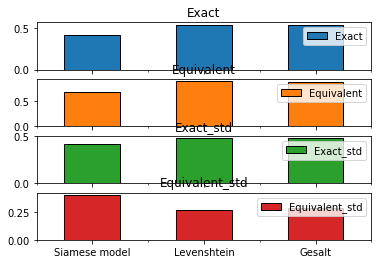

In [54]:
results.T.plot.bar(rot=0, subplots=True);

In [55]:
results.loc["Exact"].to_list()

[0.4216811185675342, 0.5465698412698412, 0.5388927265115346]

In [56]:
results.loc["Exact"].std()

0.06999368088863928

<Figure size 720x360 with 0 Axes>

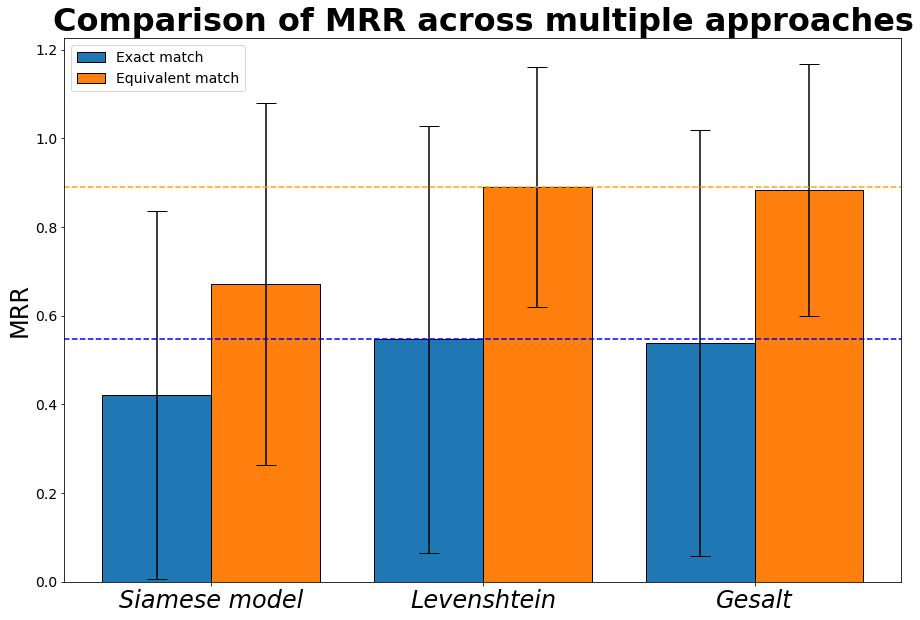

In [96]:
X = results.columns
Exact = results.loc["Exact"].to_list()
Equivalent = results.loc["Equivalent"].to_list()

X_axis = np.arange(len(X))
plt.figure(figsize=[10,5])

plt.figure(figsize=(15,10))

plt.bar(X_axis - 0.2, Exact, 0.4, yerr=results.loc["Exact_std"], capsize=10, label = 'Exact match')
plt.bar(X_axis + 0.2, Equivalent, 0.4, yerr=results.loc["Equivalent_std"], capsize=10, label = 'Equivalent match')

plt.axhline(y=max(Equivalent), color="orange", linestyle="--")
plt.axhline(y=max(Exact), color="blue", linestyle="--")
    
# plt.errorbar( X_axis - 0.2, Exact[0], yerr=results.loc["Exact_std"][0], fmt="o", color="r")
# plt.errorbar( X_axis, Exact[1], yerr=results.loc["Exact_std"][1], fmt="o", color="r")
# plt.errorbar( X_axis + 0.2, Exact[2], yerr=results.loc["Exact_std"][2], fmt="o", color="r")
    
plt.xticks(X_axis, X, style="italic", weight='regular', fontsize=24)
plt.tick_params(axis="y", labelsize= 14)
# plt.xlabel("Approaches", weight='semibold', fontsize='large')
plt.ylabel("MRR", fontsize=24)
plt.title("Comparison of MRR across multiple approaches", weight='bold', fontsize=32)
plt.legend(fontsize=14, loc='upper left')
plt.show()

# Translation tests

In [58]:
# translation = '../data/translation_test_nps_202203171038.csv'
# translation_set = preprocessInput(translation, maxlen = MAXLEN, balance= False, reflexive = False, noise = None)

In [59]:
# translation_set.head()

In [60]:
# encode_pad_tag(translation_set, 1, 0, MAXLEN)

In [61]:
# novelty = find_ranks(model, translation_set.sample(n=10), ranks=10, find_related_rank= False, report_distances=False)

In [62]:
# novelty.sample(10)

In [63]:
# test["Processed_np_name"] = test.np_name.apply(clean).apply(encode).apply(padding)

In [64]:
# test = preprocessInput(unmapped, converters = {"drug_name_original":str}, skip_blank_lines=True, na_filter=True, na_values="")
# test["Processed_drug_name_original"] = test[test.columns[0]].apply(clean).apply(encode).apply(padding)